In [84]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.optimization.ising import max_cut, tsp, common
from qiskit.aqua.algorithms import VQE, ExactEigensolver, QAOA
from qiskit.aqua.components.optimizers import SPSA, ADAM
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance
from qiskit.qasm import pi

from docplex.mp.model import Model
from qiskit.optimization.ising import docplex

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log
from qiskit import IBMQ
provider = IBMQ.load_account()

Credentials are already in use. The existing account in the session will be replaced.


### Max Cut

In [3]:
w = np.zeros([6,6])
for i in range(5):
    w[i, i+1] = 1
    w[i+1, i] = 1
w[0,5] = 1
w[5,0] = 1
w #ajacency matrix

array([[0., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1., 0.]])

In [10]:
qubitOp, offset = max_cut.get_operator(w)# get the qubit operator given the graph
qubitOp.print_details()

'IIIIZZ\t(0.5+0j)\nIIIZZI\t(0.5+0j)\nIIZZII\t(0.5+0j)\nIZZIII\t(0.5+0j)\nZIIIIZ\t(0.5+0j)\nZZIIII\t(0.5+0j)\n'

#### QAOA

In [14]:
adam = ADAM(maxiter=1000)#optimizer
qaoa = QAOA(qubitOp, adam)#QAOA solver

backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)
result = qaoa.run(quantum_instance)
print('solution:', common.sample_most_likely(result['eigvecs'][0]))

#### From Scratch

In [68]:
class circuits:
    def __init__(self, qbits, cbits):
        self.qbits = qbits
        self.cbits = cbits
        self.circ = QuantumCircuit(qbits, cbits)
        for i in range(qbits):
            self.circ.h(i)
    
    def beta_gate(self, beta, qbit):
        self.circ.u3(2*beta, -pi/2, pi/2, qbit)
        
    def gamma_gate(self, gamma, qbit0, qbit1):
        self.circ.x(qbit1)
        self.circ.u1(-gamma/2, qbit1)
        self.circ.x(qbit1)
        self.circ.u1(-gamma/2, qbit1)
        self.circ.cnot(qbit1, qbit0)
        self.circ.x(qbit0)
        self.circ.u1(gamma/2, qbit0)
        self.circ.x(qbit0)
        self.circ.u1(-gamma/2, qbit0)
        self.circ.cnot(qbit1, qbit0)
        
    def measure(self):
        for i in range(self.qbits):
            self.circ.measure(i,i)

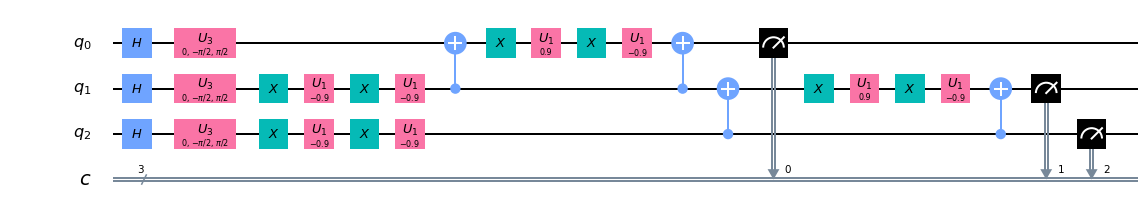

In [90]:
c = circuits(3,3)
c.beta_gate(0,0)
c.beta_gate(0,1)
c.beta_gate(0,2)
c.gamma_gate(1.8, 0, 1)
c.gamma_gate(1.8, 1, 2)

# c.beta_gate(2.094, 0)
# c.beta_gate(2.094, 1)
# c.beta_gate(2.094,2)
# c.gamma_gate(1.5, 0, 1)
# c.gamma_gate(1.5, 1, 2)

# c.beta_gate(0.094, 0)
# c.beta_gate(0.094, 1)
# c.beta_gate(0.094,2)
# c.gamma_gate(0.8, 0, 1)
# c.gamma_gate(0.8, 1, 2)

# c.beta_gate(0.094, 0)
# c.beta_gate(0.094, 1)
# c.beta_gate(0.094,2)
# c.gamma_gate(0.5, 0, 1)
# c.gamma_gate(0.5, 1, 2)

c.measure()
c.circ.draw()

In [91]:
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = execute(c.circ, backend_sim, shots=1024)

# Grab the results from the job.
result_sim = job_sim.result()
counts = result_sim.get_counts(c.circ)
print(counts)

{'000': 128, '001': 123, '011': 125, '100': 131, '110': 138, '101': 128, '111': 127, '010': 124}


In [87]:
class max_cut:
    def __init__(self, n, elist):
        self.n = n
        self.G = nx.Graph()
        self.G.add_nodes_from(np.arange(0,n,1))
        self.elist = elist
        # tuple is (i,j,weight) where (i,j) is the edge
        self.G.add_edges_from(elist)

    def draw(self):
        colors = ['w' for node in self.G.nodes()]
        pos = nx.spring_layout(self.G)
        default_axes = plt.axes(frameon=True)
        nx.draw_networkx(self.G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
        plt.show()
        
    def build_circuit(self, depth, beta, gamma):
        self.circuit = circuits(self.n, self.n)
        for i in range(depth):
            for node in range(self.n):
                self.circuit.beta_gate(beta[i],node)
            for (node0, node1) in self.G.edges:
                self.circuit.gamma_gate(gamma[i], node0, node1)
        self.circuit.measure()
        
    def solve(self):
        backend_sim = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit.circ, backend_sim, shots=1024)

        # Grab the results from the job.
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit.circ)
        print(counts)

C:\Users\Shawn\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


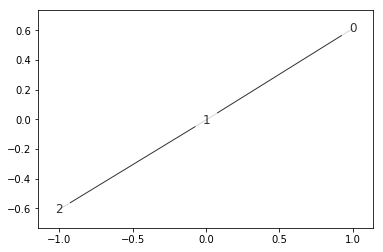

In [88]:
mc = max_cut(3, [[0,1], [1,2]])
mc.draw()

In [90]:
mc.build_circuit(depth = 1, beta = [1.4], gamma = [1.4])

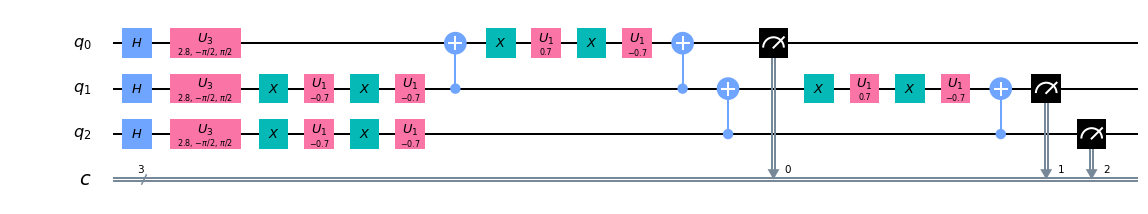

In [91]:
mc.circuit.circ.draw(output='mpl')

In [83]:
mc.solve()

{'101': 135, '000': 135, '110': 125, '011': 108, '001': 126, '010': 135, '100': 123, '111': 137}
